# TRAINING OF A MODEL FOR MASK/NO MASK DETECTION

This google collab notebook contains the code used for creating and training a machine learning model for the classification of images. The aim of this model is to classify the images in the classes: with_mask and without_mask.

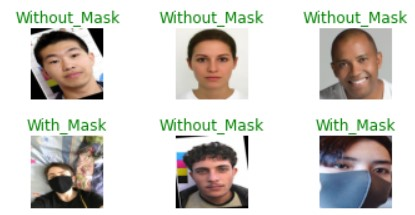

## Installation

Install the necessary libraries for performing the training, loading/parsing the dataset, display the images.

In [1]:
!pip install tensorflow
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [2]:
pd.set_option("display.precision", 8)

## Connect to google drive

Give this notebook access to your google drive where the dataset of images should be loaded before this training. I loaded my dataset in a folder called "Dwnld_Dataset_mask_classification" that contains two folder "224_resized" and "original". Once contains the original images, the other contains the same images but resized to shape 224x224.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Specify here the path where you saved the dataset in your google drive

In [4]:
data_root = 'gdrive/MyDrive/Dwnld_Dataset_mask_classification/224_resized'
// data_root = 'gdrive/MyDrive/...'

## Parse the dataset into train and validation

In [5]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="validation",shuffle=True,target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="training",shuffle=True,target_size=IMAGE_SHAPE)

gdrive/MyDrive/Dwnld_Dataset_mask_classification/224_resized
Found 1536 images belonging to 2 classes.
Found 6152 images belonging to 2 classes.


In [6]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print('\nAvailable labels are:')
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)

Available labels are:
['With_Mask' 'Without_Mask']


## Model training

### Define the model

Here is defined the model strcuture. For simplicuty I took a pre existing model structure that is MobileNet_V2. Then also the input shape and other characteristichs of the model are defined.

In [7]:
model = tf.keras.Sequential([
                            hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                                            output_shape=[1280],
                                            trainable=False),
                            tf.keras.layers.Dropout(0.4),
                            tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')])

model.build([None, 224, 224, 3])

In [8]:
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Define the parameters of the model

In [9]:
steps_per_epoch     = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
print('steps per epoch:     ' + str(steps_per_epoch))
print('val steps per epoch: ' + str(val_steps_per_epoch))

steps per epoch:     193.0
val steps per epoch: 48.0


### Start the training

The model here is trained. it should take 10 minutes circa. With just 5 epochs the results are more than satisfying.

In [10]:
§hist = model.fit(train_generator,epochs=5,verbose=1,steps_per_epoch=steps_per_epoch,validation_data=valid_generator,validation_steps=val_steps_per_epoch).history

Epoch 1/5
193/193 [==============================] - 430s 2s/step - loss: 0.0902 - acc: 0.9629 - val_loss: 0.0359 - val_acc: 0.9883
Epoch 2/5
193/193 [==============================] - 31s 162ms/step - loss: 0.0311 - acc: 0.9883 - val_loss: 0.0305 - val_acc: 0.9909
Epoch 3/5
193/193 [==============================] - 30s 156ms/step - loss: 0.0239 - acc: 0.9919 - val_loss: 0.0304 - val_acc: 0.9915
Epoch 4/5
193/193 [==============================] - 31s 161ms/step - loss: 0.0212 - acc: 0.9937 - val_loss: 0.0315 - val_acc: 0.9915
Epoch 5/5
193/193 [==============================] - 31s 161ms/step - loss: 0.0178 - acc: 0.9950 - val_loss: 0.0295 - val_acc: 0.9915


## Export the model

Locally save the model on this runtime. Then load the model with another name in order to test it and later save it in another file type.

In [11]:
MASK_SAVED_MODEL = "saved_models/mask"

model.save(MASK_SAVED_MODEL)
# load the model
mask_model = tf.keras.models.load_model(MASK_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/mask/assets


INFO:tensorflow:Assets written to: saved_models/mask/assets


In [13]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


## Test the model

### Predictions for the entire batch

Now perform a prediction for each testing image. Also save in a dataframe the results.

In [14]:
tf_model_predictions      = mask_model.predict(val_image_batch)
tf_pred_dataframe         = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,With_Mask,Without_Mask
0,0.00028805,0.99971193
1,0.99987340,0.00012664
2,0.00009100,0.99990904
3,0.00000008,0.99999988
4,0.99997509,0.00002494


### Plot random images and their predictions (green=correct, red=incorrect)

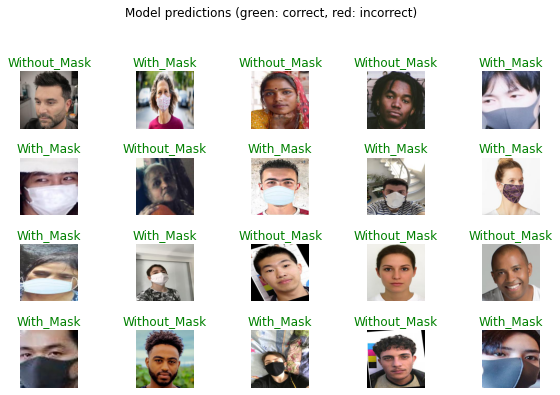

In [15]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Download model

In this section the model is converted in a json friendly format and then the entire folder containing all the files of the model is downloaded. In order to use the tfjs converter it's necessary to install its library.

### Convert to web friendly format

In [16]:
!pip install tensorflowjs
%mkdir /content/converted_model

     |████████████████████████████████| 77 kB 3.1 MB/s 


This is the signle line of code that will convert the file in a json file and save it in the correct folder.

In [17]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model  --skip_op_check --saved_model_tags=serve --strip_debug_ops=True --weight_shard_size_bytes=4194304  "/content/saved_models/mask" "/content/saved_models/converted_model/"

2022-01-03 16:15:58.119566: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file /content/saved_models/converted_model/model.json...


### Download saved_model and json model

Here the entire fodler is downloaded as a zip file.

In [18]:
%cd '/content'
from google.colab import files
import shutil
shutil.make_archive('classification_model', 'zip', 'saved_models')
files.download('classification_model.zip') 

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>